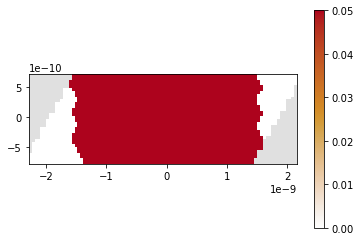

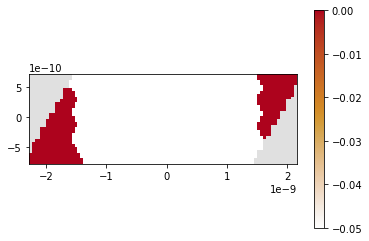

In [10]:
### See graphene quantum dot file for more documentation
# Basically the same notebook, just using a nanoribbon instead and realistic units
# likely will not run without modified version of kwant



import matplotlib.pyplot as plt
import numpy as np
import kwant
import scipy.sparse.linalg as sla
import scipy.linalg as la
from tqdm import tqdm
from math import *
import scipy.integrate as integrate
import tinyarray

k_b = 1.380649e-23 #m^2 kg/s^2/K
q_e = 1.6e-19
h = 6.626176e-34 # in meter
hbar = 1.054571e-34 # in meters


sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

# h=4.1357e-15 # ev * s
# hbar = 6.5821e-16 # ev * s
# q_e = 1

ev_to_j = 1.6e-19



def make_system(L, W, t, tp, left_pot, right_pot, leads, parallel = True):
    norbs = 2
    side = -1e-10
    if L > 1:
        L *= 1e-10
    if W > 1:
        W *= 1e-10

    a = 2.46e-10 # angstroms
    # Define the graphene lattice
    sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
    lat = kwant.lattice.general([(a, 0), (a*sin_30, a*cos_30)],
                                 [(0, 0), (0, a / sqrt(3))], norbs=norbs)

    b,c = lat.sublattices

    # hopping along the A field direction (perpendicular to B field)
    def hopy(site1, site2, B):
        x = site1.pos[0]
        return sigma_0 * t * np.exp(1j * B * x * q_e/hbar * a / sqrt(3))
        # try e / (hbar c)

    def hop_right(site1, site2, B):
        x_0 = site1.pos[0]
        const = -B*x_0*a/sqrt(12)-B*a**2/(4*sqrt(12)) # computed with pierels integral
        return sigma_0 * t * np.exp(1j * const * q_e/hbar)

    def hop_left(site1, site2, B):
        x_0 = site1.pos[0]
        const = -B*x_0*a/sqrt(12)+B*a**2/(4*sqrt(12)) # computed with pierels integral
        return sigma_0 * t * np.exp(1j * const * q_e/hbar)


    def rect(pos):
        x, y = pos
        return abs(2*y) < W and abs(2*x) < L

    def make_lead(pot):
        # Start with an empty lead with a single square lattice
        lead_lattice = kwant.lattice.honeycomb(a, norbs=norbs)

        sym_lead = kwant.TranslationalSymmetry(lead_lattice.vec((-1,0)))
        lead = kwant.Builder(sym_lead, conservation_law=-sigma_z)

        def lead_shape(pos):
            x, y = pos
            return abs(2*y) < W

        lead[lead_lattice.shape(lead_shape, (0, 0))] = pot * sigma_0

        lead[lead_lattice.neighbors()] = t * sigma_0
        return lead

    def potential(site, E_z):
        x,y = site.pos
        m = (left_pot - right_pot)/L
        if not parallel and x < 0:
            E_z *= -1
        return (-m*(x-L) + right_pot) * sigma_0 + E_z * sigma_z

    syst = kwant.Builder()
    syst[lat.shape(rect, (0, 0))] = potential

    ## hoppings
    hoppings_up = ((0,0),b,c)
    syst[kwant.builder.HoppingKind(*hoppings_up)] = hopy

    hoppings_left = ((0, 1), b, c)
    syst[kwant.builder.HoppingKind(*hoppings_left)] = hop_left

    hoppings_right = ((-1, 1), b, c)
    syst[kwant.builder.HoppingKind(*hoppings_right)] = hop_right
    ## hop_right and left might be swapped, pretty sure they are correct though

    syst.eradicate_dangling()

    if leads:
        syst.attach_lead(make_lead(pot = left_pot * sigma_0))
        syst.attach_lead(make_lead(pot = right_pot * sigma_0).reversed())

    if tp:
        syst[lat.neighbors(2)] = tp

    return syst


def hopping_lw(site1, site2):
    return 0.04 if site1.family == site2.family else 0.1

def sort_evals(vals, vecs):
    vecs = [vecs[:,n] for n in range(len(vals))]
    print(np.shape(vecs), np.shape(vals))
    temp = sorted(zip(vals, vecs))
    vecs = list(np.array(temp)[:,1])
    return np.array(temp)[:,0], vecs

def plot_data(syst, ns,params):
    ham = syst.hamiltonian_submatrix(sparse=True, params = params)
    print("Solving N={} matrix".format(ham.shape[0]))
    evals, evecs = sla.eigsh(ham, max(ns)+1)
    evals, evecs = sort_evals(evals, evecs)
    for n in ns:
        wf = abs(evecs[n])**2
        def site_size(i):
            return 3 * wf[i] / wf.max()
        kwant.plot(syst, site_size=site_size, site_color=(0, 1, 1, 0.3),
               hop_lw=0.1, fig_size=(6,6))
    plt.plot(evals)
    plt.show()


t = -2.7 * ev_to_j
doping_level = 0
v_sd = 0

left_pot = v_sd/2
right_pot = -v_sd/2

syst = make_system(L = 30, W = 15,t=-t, left_pot=left_pot
                   , right_pot=right_pot, tp=None, leads = True, parallel=True)
syst = syst.finalized()

def spin_up_map(i):
    spin_up_mask = tinyarray.array([[1,0],[0,0]])
    hamiltonian = syst.hamiltonian(i, i, params=dict(B=0, E_z = 0.05*ev_to_j))
    return np.sum(spin_up_mask * hamiltonian)/ ev_to_j
kwant.plotter.map(syst, spin_up_map);

def spin_down_map(i):
    spin_down_mask = tinyarray.array([[0,0],[0,1]])
    hamiltonian = syst.hamiltonian(i, i, params=dict(B=0, E_z = 0.05*ev_to_j))
    return np.sum(spin_down_mask * hamiltonian)/ ev_to_j
kwant.plotter.map(syst, spin_down_map);

 65%|██████████████████████████████████████████████████████████████████████████                                        | 65/100 [00:06<00:03,  9.79it/s]/tmp/ipykernel_5616/3963195584.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp((eps-mu)/(k_b*T)))
 66%|███████████████████████████████████████████████████████████████████████████▏                                      | 66/100 [00:06<00:03,  9.73it/s]/tmp/ipykernel_5616/3963195584.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp((eps-mu)/(k_b*T)))
 67%|████████████████████████████████████████████████████████████████████████████▍                                     | 67/100 [00:06<00:03,  9.19it/s]/tmp/ipykernel_5616/3963195584.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp((eps-mu)/(k_b*T)))
 68%|█████████████████████████████████████████████████████████████████████████████▌                                    | 68/100 [00:06<00:03,  9.17it/s]/tmp/ipykernel_5616/396319558

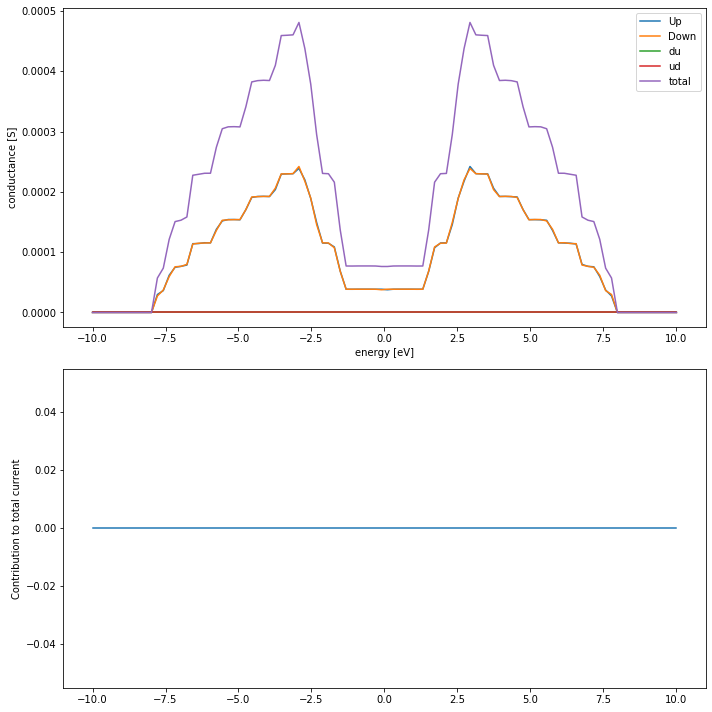

In [13]:
def fermi(eps, mu, T):
    return 1/(1+np.exp((eps-mu)/(k_b*T)))

def plot_conductance(syst, energies, mu_left, mu_right, temp, params, silent=False):
    # Compute transmission as a function of energy
    spin_ups = []
    spin_downs = []
    down_up = []
    up_down = []
    total = []

    data2 = []
    current_sum = 0
    dE = energies[1] - energies[0]

    iter_energies = energies
    if not silent:
        iter_energies = tqdm(iter_energies)

    for energy in iter_energies:
        smatrix = kwant.smatrix(syst, energy, params = params)


        # total conductance
        spin_ups.append(smatrix.transmission((1,0), (0,0))*q_e**2/h)
        spin_downs.append(smatrix.transmission((1,1), (0,1))*q_e**2/h)
        down_up.append(smatrix.transmission((1,0), (0,1))*q_e**2/h)
        up_down.append(smatrix.transmission((1,1), (0,0))*q_e**2/h)
        total.append(smatrix.transmission(1,0) * q_e**2 / h)
        # smatrix.transmission((1,0), (0,0)) # look at spin ups

        current_sum += dE * (total[-1]) * (fermi(energy,mu_left, temp) - fermi(energy, mu_right, temp)) / q_e

        data2.append((total[-1])*(fermi(energy, mu_left, temp) - fermi(energy, mu_right, temp)))

    if not silent:
        fig, axs = plt.subplots(2,figsize=(10,10))
        axs[0].plot(energies/ev_to_j, spin_ups, label="Up")
        axs[0].plot(energies/ev_to_j, spin_downs, label = "Down")
        axs[0].plot(energies/ev_to_j, down_up, label="du")
        axs[0].plot(energies/ev_to_j, up_down, label = "ud")
        axs[0].plot(energies/ev_to_j, total, label = "total")
        axs[0].set_xlabel("energy [eV]")
        axs[0].set_ylabel("conductance [S]")
        axs[0].legend()

        axs[1].plot(energies/ev_to_j, data2)
        axs[1].set_ylabel("Contribution to total current")

        plt.tight_layout()
        plt.savefig("graphs/conductance plot")
        plt.show()
    return current_sum, energies, total, spin_downs, spin_ups


def plot_bandstructure(flead, momenta):
    bands = kwant.physics.Bands(flead)
    energies = [bands(k)/ev_to_j for k in tqdm(momenta)]

    plt.figure(figsize=(10,6))
    plt.plot(momenta, energies,alpha=0.5)

    plt.xlabel("momentum [(lattice constant)^-1]")
    plt.ylabel("energy [ev]")
    plt.grid()
    plt.show()
    return energies

def make_IV_curve(voltages, temp):
    currents = []
    if -doping_level*2 in voltages:
        print("Remove 0 term otherwise we get 0 momentum modes")
    for v_sd in voltages:
        left_pot = v_sd/2
        right_pot = -v_sd/2
        syst = make_system(r=150,t=-t, left_pot=left_pot, right_pot=right_pot, tp=None, leads = True)

        syst = syst.finalized()

        span = left_pot - right_pot
        energies = np.linspace(doping_level-span, doping_level+span, 70)
        current, _, _ = \
            plot_conductance(syst, energies,
            doping_level+left_pot, doping_level+right_pot, temp, silent=True)
        print("Current for {}V = {}".format(v_sd, current))
        currents.append(current)
    return currents



def plot_spectrum(syst, Bfields, k):
    energies = []
    for B in tqdm(Bfields):
        # Obtain the Hamiltonian as a sparse matrix
        ham_mat = syst.hamiltonian_submatrix(params=dict(B=0, E_z=B), sparse=True)

        # we only calculate the k lowest eigenvalues
        ev = sla.eigsh(ham_mat.tocsc(), k=k, sigma=0,
                       return_eigenvectors=False)

        energies.append(ev)

    return Bfields, energies



syst = make_system(L = 30, W = 15,t=-t, left_pot=left_pot
                   , right_pot=right_pot, tp=None, leads = True, parallel=False)
syst = syst.finalized()
temp = 50
energies = np.linspace(-10*ev_to_j, 10*ev_to_j , 100)
params = dict(B=0, E_z = 0.1*ev_to_j)

current, voltages, conductances, down_conductance, up_conductance = \
    plot_conductance(syst, energies, doping_level+left_pot, doping_level+right_pot, temp,
                     params = params, silent=False)

In [14]:
q_e**2/h

3.863465141885757e-05